In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend, find_peaks

In [2]:
data_dir = "/Users/harikrishnans/Downloads/ils/data/calibrated"

In [3]:
# Function to load data for a specific date
def load_data(year, month, day):
    folder_path = os.path.join(data_dir, f"{year:04d}{month:02d}{day:02d}/")
    all_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(".csv")]
    data_list = []
    for file in all_files:
        df = pd.read_csv(file)
        data_list.append(df)
    
    return pd.concat(data_list, ignore_index=True)
    

In [4]:
year, month, day = 2023, 8, 30
data = load_data(year, month, day)

In [5]:
print("Data Columns:", data.columns)
print("Sample Data:\n", data.head())

Data Columns: Index(['Time', 'xTemp', 'zTemp', 'yTemp', 'X Coarse Acceleration',
       'Y Coarse Acceleration', 'Z Coarse Acceleration', 'X Fine Acceleration',
       'Y Fine Acceleration', 'Z Fine Acceleration'],
      dtype='object')
Sample Data:
                           Time  xTemp  zTemp  yTemp  X Coarse Acceleration  \
0  2023-08-30T22:25:25.064000Z     40     40     40               0.643095   
1  2023-08-30T22:25:25.064000Z     40     40     40               0.643095   
2  2023-08-30T22:25:25.072000Z     40     40     40               0.642796   
3  2023-08-30T22:25:25.072000Z     40     40     40               0.642796   
4  2023-08-30T22:25:25.080000Z     40     40     40               0.642796   

   Y Coarse Acceleration  Z Coarse Acceleration  X Fine Acceleration  \
0               0.737875              -0.336232             0.030935   
1               0.738139              -0.336232             0.030935   
2               0.738139              -0.336765             0.03

In [6]:
timestamp = pd.to_datetime(data['Time'])
acc_x = data['X Coarse Acceleration']  
acc_y = data['Y Coarse Acceleration'] 
acc_z = data['Z Coarse Acceleration'] 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


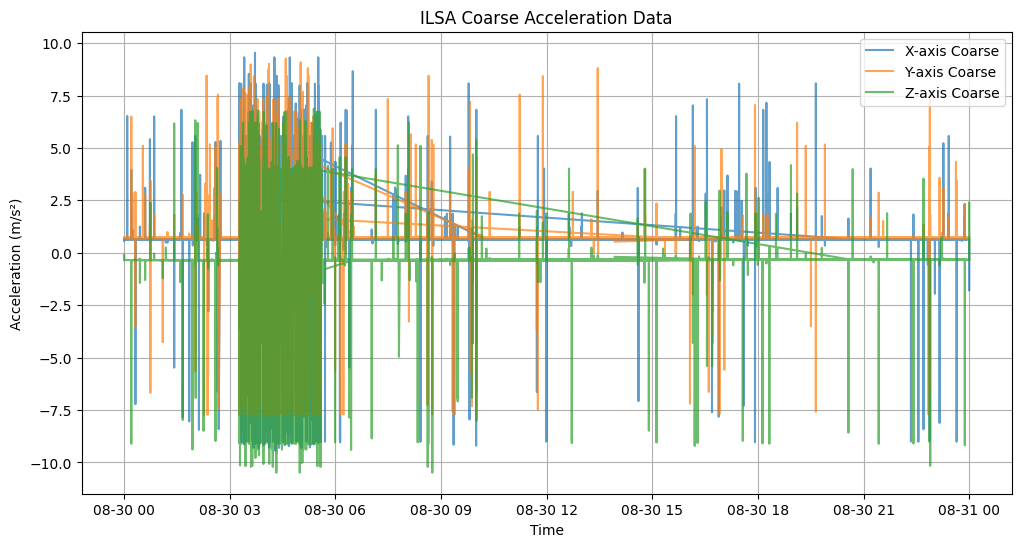

In [7]:
# Visualization of raw coarse acceleration data
plt.figure(figsize=(12, 6))
plt.plot(timestamp, acc_x, label='X-axis Coarse', alpha=0.7)
plt.plot(timestamp, acc_y, label='Y-axis Coarse', alpha=0.7)
plt.plot(timestamp, acc_z, label='Z-axis Coarse', alpha=0.7)
plt.legend()
plt.title("ILSA Coarse Acceleration Data")
plt.xlabel("Time")
plt.ylabel("Acceleration (m/s²)")
plt.grid()
plt.show()

In [9]:
# Detrend the coarse acceleration data
acc_x_detrended = detrend(acc_x)
acc_y_detrended = detrend(acc_y)
acc_z_detrended = detrend(acc_z)


In [10]:
# Detect potential seismic events using fine acceleration data (example)
fine_acc_x = data['X Fine Acceleration']
fine_acc_y = data['Y Fine Acceleration']
fine_acc_z = data['Z Fine Acceleration']


In [13]:
threshold = np.std(fine_acc_x) * 3  # threshold (2x standard deviation)
peaks_x, _ = find_peaks(fine_acc_x, height=threshold)
peaks_y, _ = find_peaks(fine_acc_y, height=threshold)
peaks_z, _ = find_peaks(fine_acc_z, height=threshold)


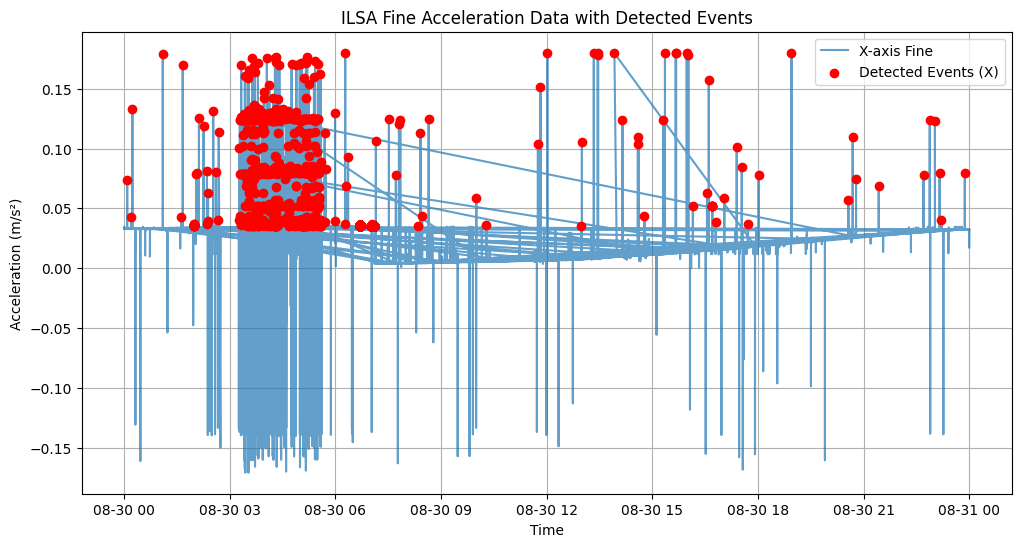

In [14]:
# Plot fine acceleration data with detected events
plt.figure(figsize=(12, 6))
plt.plot(timestamp, fine_acc_x, label='X-axis Fine', alpha=0.7)
plt.scatter(timestamp[peaks_x], fine_acc_x[peaks_x], color='red', label='Detected Events (X)', zorder=5)
plt.legend()
plt.title("ILSA Fine Acceleration Data with Detected Events")
plt.xlabel("Time")
plt.ylabel("Acceleration (m/s²)")
plt.grid()
plt.show()

In [15]:
#Advanced Event Detection
#Objective - Refine event detection using advanced algorithms like STA/LTA (Short-Term Average / Long-Term Average).


In [16]:
from obspy.signal.trigger import classic_sta_lta, trigger_onset

In [17]:
# Parameters for STA/LTA
sta_window = 1  
lta_window = 20  
sampling_rate = 100  


In [18]:
# Apply STA/LTA to fine acceleration data (X-axis example)
nsta = int(sampling_rate * sta_window)
nlta = int(sampling_rate * lta_window)
sta_lta = classic_sta_lta(fine_acc_x.values, nsta, nlta)


In [19]:
# Detect triggers based on STA/LTA thresholds
trigger_threshold = 2.0  # Threshold to declare event
detrigger_threshold = 0.5  # Threshold to end event
triggers = trigger_onset(sta_lta, trigger_threshold, detrigger_threshold)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


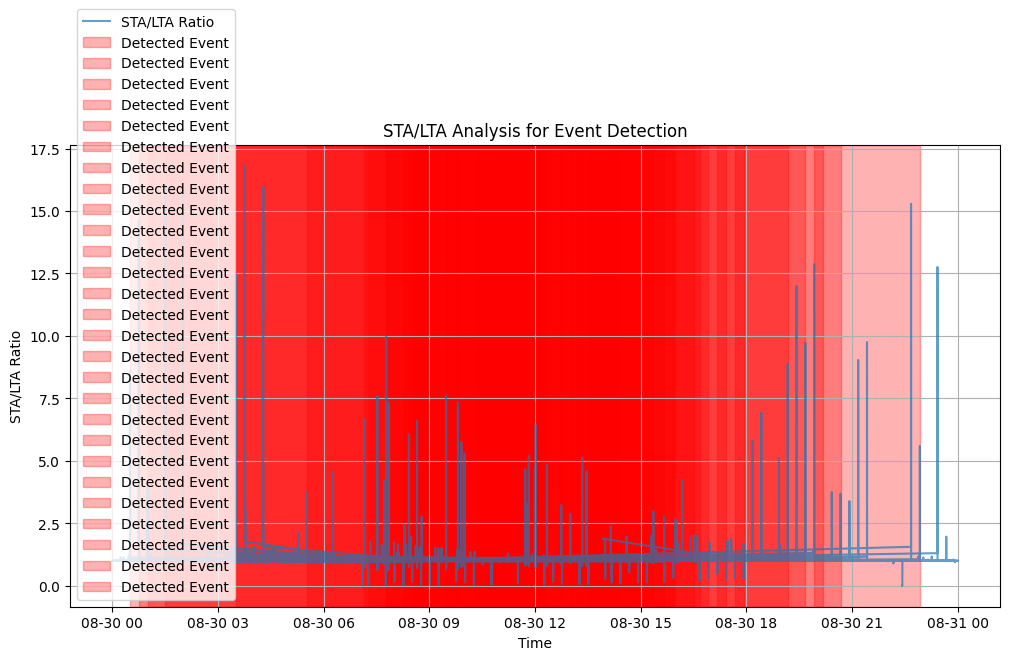

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(timestamp, sta_lta, label="STA/LTA Ratio", alpha=0.7)
for trigger in triggers:
    plt.axvspan(timestamp[trigger[0]], timestamp[trigger[1]], color='red', alpha=0.3, label='Detected Event')
plt.legend()
plt.title("STA/LTA Analysis for Event Detection")
plt.xlabel("Time")
plt.ylabel("STA/LTA Ratio")
plt.grid()
plt.show()

In [21]:
#Feature extraction for event classification

In [22]:
from scipy.fft import fft

In [23]:
features = []
sampling_rate = 100  

for start_idx, end_idx in triggers:
    if start_idx < end_idx: 
        event_data = fine_acc_x[start_idx:end_idx].values  
        max_amplitude = np.max(event_data)
        duration = (end_idx - start_idx) / sampling_rate
        # Perform FFT
        frequencies = np.fft.fftfreq(len(event_data), d=1/sampling_rate)
        fft_values = fft(event_data)
        dominant_frequency = frequencies[np.argmax(np.abs(fft_values))]

        features.append({
            'start_time': timestamp[start_idx],
            'end_time': timestamp[end_idx],
            'max_amplitude': max_amplitude,
            'duration': duration,
            'dominant_frequency': dominant_frequency
        })


In [24]:
features_df = pd.DataFrame(features)
print(features_df)

                         start_time                         end_time  \
0  2023-08-30 07:09:06.848000+00:00 2023-08-30 17:25:25.320000+00:00   
1  2023-08-30 12:44:37.072000+00:00 2023-08-30 07:15:50.856000+00:00   
2  2023-08-30 01:30:00.048000+00:00 2023-08-30 16:40:25.184000+00:00   
3  2023-08-30 01:00:00.176000+00:00 2023-08-30 13:15:51.056000+00:00   
4  2023-08-30 13:20:17.096000+00:00 2023-08-30 17:55:25.264000+00:00   
5  2023-08-30 11:43:21.272000+00:00 2023-08-30 08:30:50.928000+00:00   
6  2023-08-30 08:39:00.280000+00:00 2023-08-30 15:55:25.216000+00:00   
7  2023-08-30 15:58:35.728000+00:00 2023-08-30 14:10:25.088000+00:00   
8  2023-08-30 16:30:53.048000+00:00 2023-08-30 07:45:50.856000+00:00   
9  2023-08-30 07:46:33.088000+00:00 2023-08-30 14:55:25.056000+00:00   
10 2023-08-30 22:55:25.160000+00:00 2023-08-30 17:40:25.264000+00:00   
11 2023-08-30 14:09:05.120000+00:00 2023-08-30 10:15:51.008000+00:00   
12 2023-08-30 19:10:24.992000+00:00 2023-08-30 17:10:25.368000+0

In [25]:
features_df.to_csv('/Users/harikrishnans/Downloads/ils/data/untitled folder/features_df_20230830.csv')